# Assignment 3: Part 1 - Regression
- Group Number: A-129
- Name: Uzair Mohiuddin
- Student Number: 8737165

## Introduction
This notebook is used to perform a linear regression analysis of the Medical Insurance Cost dataset. We will perform all the major tasks involved in a linear regression including:
1. Cleaning data
2. Categorical feature encoding
3. EDA and Outlier Detection
4. Predictive Analysis: Linear Regression
5. Feature Engineering
6. Empirical Study
7. Result Analysis

## Dataset Description: Medical Cost Personal Assets
- **Dataset**: Medical Forecast by using Linear Regression
- **Author**: Miri Choi
- **Source**: [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance)
- **Purpose**: The dataset represents the medical insurance costs and related factors such as age, sex, bmi, children, smiking, region, and charges.
- **Shape**: 1338 rows x 7 columns
- **Features of Dataset**:
  | Feature | Categorical/Numerical | Description |
  | ------- | --------------------- | ----------- |
  | age     | Numerical (int64)     | Age |
  | sex     | Categorical (object)  | Insurance contractor gender (male/female) |
  | bmi     | Numerical (float64) | Body Mass Index (kg / m^2) |
  | children | Numerical (int64)  | Number of children covered by health insurance |
  | smoker  | Categorical (object) | Smoking (yes/no) |
  | region  | Categorical (object) | Beneficiary's residential area (northeast, southeast, southwest, northwest) |
  | charges | Numerical (float64) | Individual medical costs billed by health insurance |
  

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from IPython.display import display, Markdown

In [2]:
# URL for dataset
insurance_dataset_url = "https://raw.githubusercontent.com/uzaaaiiir/jupyter/refs/heads/main/intro_ds_assignments/assignment3/insurance.csv"

# Load dataset
df = pd.read_csv(insurance_dataset_url)

In [3]:
# Shape of dataset
df.shape

(1338, 7)

In [4]:
# Get list of features and descriptions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
'''
describe() to retrieve numerical attributes.

Numerical attributes: age, bmi, children, charges
'''
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
'''
Categorical attributes of the dataset.

Categorical attributes are: sex, smoker, region
'''
df.describe(include="object")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Regression Empirical Study

## 1. Clean Data
This step involves performing validity checks and imputation of missing data. 

In [8]:
'''
Presence Check
- No attributes are missing values. 
'''
df_copy = df.copy(deep=True)

attributes = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
test = 'charges'

missing = df_copy[df_copy[test].isna()]
missing

,age,sex,bmi,children,smoker,region,charges


In [9]:
'''
Range Check:
- There are no values out of range.
'''
attributes = ['age', 'bmi', 'children', 'charges']

valid_ranges = {
    "age": (0, 120),
    "bmi": (10, 60),
    "children": (0, 10),
    "charges": (0, 1000000)
}

test = "children"
out_of_range = df_copy[(df_copy[test] < 0) | (df_copy[test] > 10)]
out_of_range

,age,sex,bmi,children,smoker,region,charges


In [10]:
'''
Lookup check
- No attributes have invalid values
'''
attributes = ['sex', 'smoker', 'region']

valid_categories = {
    "sex": {"male", "female"},
    "smoker": {"yes", "no"},
    "region": {"northeast", "northwest", "southeast", "southwest"}
}

# Check for invalid category values
for col, valid_values in valid_categories.items():
    invalid_values = df_copy[~df_copy[col].isin(valid_values)]
    if not invalid_values.empty:
        print(f"Warning: {col} contains invalid values")
        print(invalid_values[col].unique())

## 2. Categorical Feature Encoding
Performing one-hot encoding to transform categorical features into numerical features. 

In [11]:
'''
One-Hot Encoding
- We can convert sex, smoker, and region into numerical attributes using one-hot encoding.
'''
df_copy['sex'] = df_copy['sex'].map({'male': 1, 'female': 0})
df_copy['smoker'] = df_copy['smoker'].map({'yes': 1, 'no': 0})
df_copy = pd.get_dummies(df_copy, columns=['region']).astype(int)

df_copy

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27,0,1,16884,0,0,0,1
1,18,1,33,1,0,1725,0,0,1,0
2,28,1,33,3,0,4449,0,0,1,0
3,33,1,22,0,0,21984,0,1,0,0
4,32,1,28,0,0,3866,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30,3,0,10600,0,1,0,0
1334,18,0,31,0,0,2205,1,0,0,0
1335,18,0,36,0,0,1629,0,0,1,0
1336,21,0,25,0,0,2007,0,0,0,1


## 3. EDA and Outlier Detection
1. Perform outlier detection using Local Outlier Factor (LOF).
2. Use EDA to visualize data and find which feature LOF should be used on. If there are no features with outliers, then introduce some outliers for at least one feature to use LOF to detect them.
3. Decide what to do with outliers (remove them or impute them).

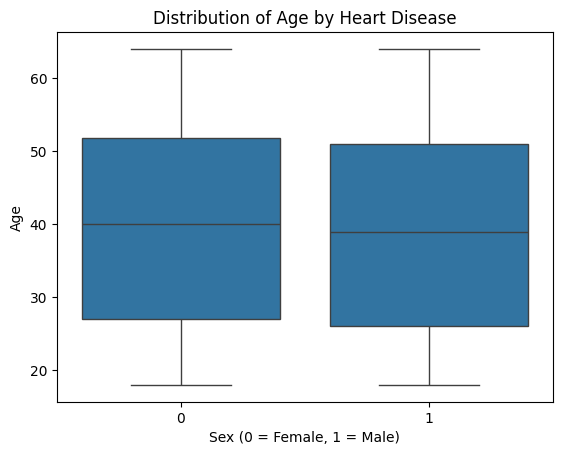

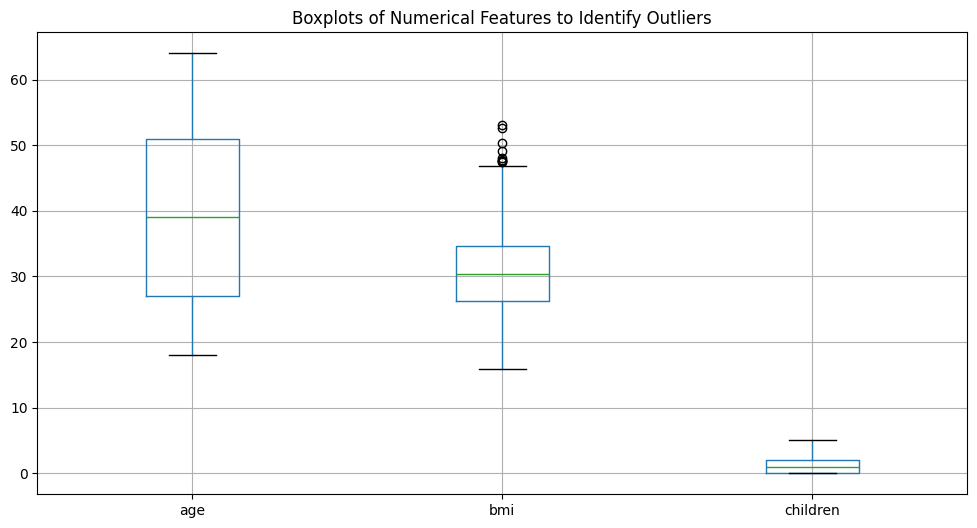

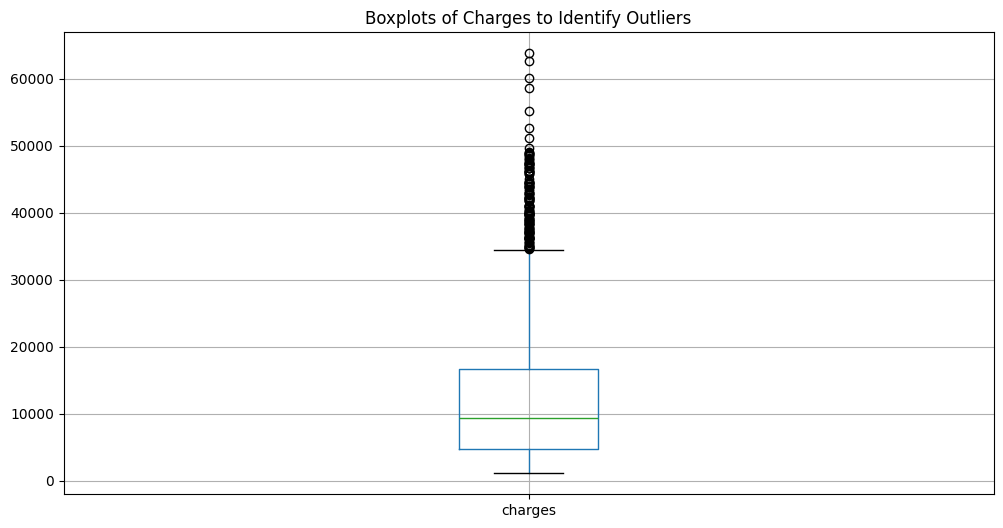

In [12]:
'''
EDA to visualize data and outliers.
- Charges and BMI have several outliers.
'''
numerical_attributes = ['age', 'bmi', 'children']

sns.boxplot(x="sex", y="age", data=df_copy)
plt.title("Distribution of Age by Heart Disease")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Age")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(12, 6))
df[numerical_attributes].boxplot()
plt.title("Boxplots of Numerical Features to Identify Outliers")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(12, 6))
df[['charges']].boxplot()
plt.title("Boxplots of Charges to Identify Outliers")
plt.show()

In [13]:
'''
Applying Local Outlier Factor to detect outliers.
'''

numerical_attributes = ['age', 'bmi', 'children', 'charges']

lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(df_copy[numerical_attributes])

df_copy['lof'] = (outlier_labels == -1).astype(int)
print(f"Number of Outliers Detected: {df_copy['lof'].sum()}")


df_copy[df_copy['lof'] == 1]

Number of Outliers Detected: 20


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest,lof
34,28,1,36,1,1,51194,0,0,0,1,1
77,21,1,35,0,0,1532,0,0,1,0,1
199,64,0,39,0,0,14901,1,0,0,0,1
374,20,1,33,0,0,1391,0,0,1,0,1
380,27,0,17,2,1,15006,1,0,0,0,1
398,64,1,25,2,0,14988,0,0,0,1,1
462,62,0,38,2,0,15230,1,0,0,0,1
478,21,1,36,0,0,1534,0,0,1,0,1
543,54,0,47,0,1,63770,0,0,1,0,1
577,31,0,38,1,1,58571,1,0,0,0,1


In [14]:
'''
We identified 20 outliers. Let's remove them.
'''
df_cleaned = df_copy[df_copy['lof'] == 0].drop(columns=['lof'])

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1318 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   age               1318 non-null   int64
 1   sex               1318 non-null   int64
 2   bmi               1318 non-null   int64
 3   children          1318 non-null   int64
 4   smoker            1318 non-null   int64
 5   charges           1318 non-null   int64
 6   region_northeast  1318 non-null   int64
 7   region_northwest  1318 non-null   int64
 8   region_southeast  1318 non-null   int64
 9   region_southwest  1318 non-null   int64
dtypes: int64(10)
memory usage: 113.3 KB


## 4. Predictive Analysis (Linear Regression)
Explore Linear Regression using scikit-learn.

In [15]:
'''
Linear Regression
'''
X = df_copy.drop(columns=['charges'])
y = df_copy['charges']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lin Regression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y)

# Predict
y_pred = lin_reg.predict(X_scaled)

# Performance
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

MSE: 35831109.62
R² Score: 0.76


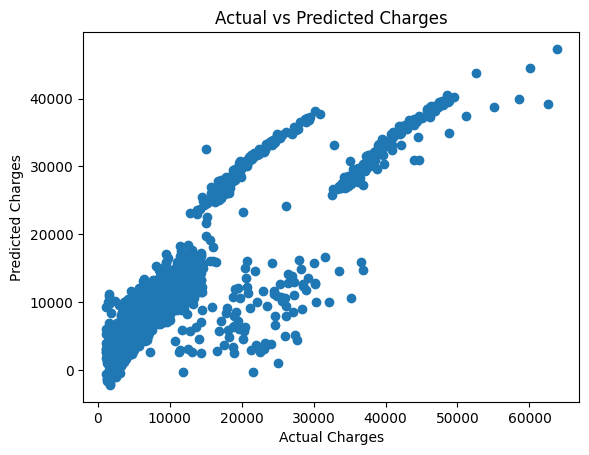

In [16]:
plt.scatter(y, y_pred)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.show()

## 5. Feature Engineering
Program a feature aggregator to create 2 additional features. This involves thinking of interesting ways to combine features based on the dataset and what could make sense. 

In [17]:
'''
Feature aggregation:
- bmi * age might tell us if older individuals with higher bmi have higher costs.
- children per age
'''
df_aggregate = df_copy.copy(deep=True)

df_aggregate['bmi_age'] = df_aggregate['bmi'] * df['age']
df_aggregate['children_per_age'] = df_aggregate['children'] / (df_aggregate['age'] + 1)  

print(df_aggregate[['bmi', 'age', 'bmi_age', 'children', 'children_per_age']].head())

   bmi  age  bmi_age  children  children_per_age
0   27   19      513         0          0.000000
1   33   18      594         1          0.052632
2   33   28      924         3          0.103448
3   22   33      726         0          0.000000
4   28   32      896         0          0.000000


## 6. Empirical Study
1. Split data into 3 subsets for train, validation, and test sets.
2. Decide on evaluation metrics (MSE, LMSE, R2).
3. Use linear regression with baseline settings, without outlier removal and without feature aggregation. Evaluate on a validation set using a 4-fold cross validation.
4. Try different combinations. Find the best system.
5. Decide on the final system which is the best one according to the study. 

In [18]:
'''
Empirical Study
- Split dataset into 3 subsets.
'''
df_copy.drop(columns=['lof'], inplace=True, errors='ignore')
X = df_copy.drop(columns=['charges'])
y = df_copy['charges']

# Split training data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [19]:
'''
Evaluation Method: MSE and R2
'''
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    return mse, r2

'''
Perform linear regression
'''
def evaluate_cross_validation(X, y, model=LinearRegression()):
    """Performs 4-Fold Cross-Validation and returns average scores."""
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    mse_scores, r2_scores = [], []

    for train_index, val_index in kf.split(X):
        X_fold_train, X_fold_val = X.iloc[train_index], X.iloc[val_index]
        y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]

        # Train model
        model.fit(X_fold_train, y_fold_train)

        # Evaluate model
        y_pred = model.predict(X_fold_val)
        mse = mean_squared_error(y_fold_val, y_pred)
        r2 = r2_score(y_fold_val, y_pred)

        mse_scores.append(mse)
        r2_scores.append(r2)

    return np.mean(mse_scores), np.mean(r2_scores)

In [20]:
'''
Baseline
'''
mse_baseline, r2_baseline = evaluate_cross_validation(X_train_val, y_train_val)

# Print Average Scores
print(f"Average MSE: {np.mean(mse_baseline):.4f}")
print(f"Average R²: {np.mean(r2_baseline):.4f}")

Average MSE: 37927282.7341
Average R²: 0.7358


In [21]:
# Outlier removal
X_no_outliers = df_cleaned.drop(columns=['charges'])
y_no_outliers = df_cleaned['charges']
mse_outliers, r2_outliers = evaluate_cross_validation(X_no_outliers, y_no_outliers)

# Print Average Scores
print(f"Average MSE: {np.mean(mse_outliers):.4f}")
print(f"Average R²: {np.mean(r2_outliers):.4f}")

Average MSE: 34726447.1364
Average R²: 0.7466


In [22]:
# Feature Aggregation
X_aggregate = df_aggregate.drop(columns=['charges'])
y_aggregate = df_aggregate['charges']
mse_aggregate, r2_aggregate = evaluate_cross_validation(X_aggregate, y_aggregate)

# Print Average Scores
print(f"Average MSE: {np.mean(mse_aggregate):.4f}")
print(f"Average R²: {np.mean(r2_aggregate):.4f}")

Average MSE: 36964777.3794
Average R²: 0.7451


In [23]:
'''
The outlier removal produces the best system. 
We can use it to perform final evaluation on the test set. 
'''
best_model = LinearRegression()
best_model.fit(X_no_outliers, y_no_outliers)

# Final Evaluation on Test Set
print("\nFinal Model Evaluation on Test Set:")
evaluate_model(best_model, X_test, y_test)


Final Model Evaluation on Test Set:
MSE: 33397010.1436
R²: 0.7849


(33397010.143641558, 0.7848801899262803)

## 7. Result Analysis
Analyse the results and discuss how outlier detection and feature aggregation affected the results.

|System | Average MSE |Average R2 |
| ------ | ----------| ----------|
| Baseline | 37,927,283 | 0.7358 |
| Remove outliers | 34,726,446 | 0.7466 |
| Aggregate | 36,964,777 | 0.7451 |

Based on the above results, the method to remove outliers produced the best results. When we evaluated the data against the test data that wasn't used before, the MSE reduced further to 33,397,010 and R2 of 0.7849. 
- Outlier removal had a positive impact of significantly reducing the MSE and improving R2. The final model performed better on the unseen data.
- Feature aggregation slightly improve R2, but the MSE was worse. Aggregating features may have introduced noise that skewed results. 

# Conclusion
The overall conclusion was that we improved linear regression performance by removing outliers, using the Local outlier factor (LOF) method. The MSE reduced from 37M at baseline to 33M when outliers were removed. The R2 increased from 0.7358 at baseline to 0.7849 when outliers were removed. We prepared this data by cleaning it and performing one-hot encoding for the sex, region, and smoker attributes. We identified outliers and then performed a comparative analysis of the linear regression performance when different data was used. We tested baseline, removal of outliers, and aggregation of attributes.

# References
- Week 7 Predictive Analysis Linear Regression Lecture
- ChatGTP Prompts
  - How do we perform a 4-fold cross-validation using linear regression in Jupyter Notebooks?
  - What is the library and method to perform Local Outlier Detection?